Loading ECG Data/223DF2.txt


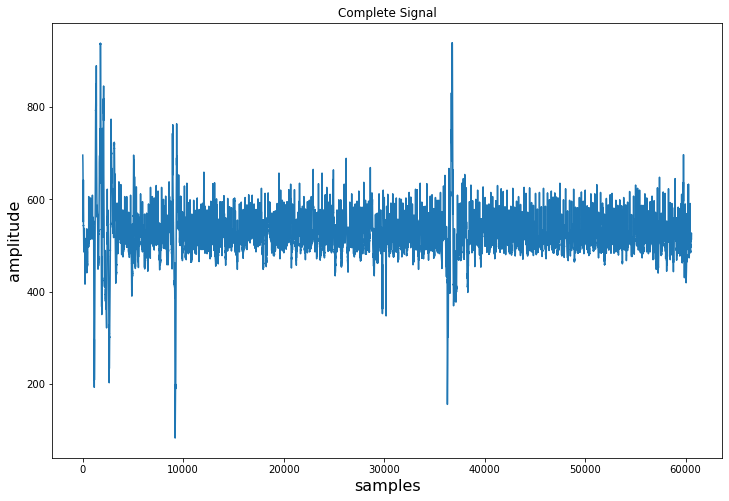

   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  890.663717  91.664839   35.265641   85.248477   31.558828   89.713791   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  HRV_CVNN  HRV_CVSD  \
0         NaN         NaN   81.71742  81.838571  0.102917  0.091749   

   HRV_MedianNN  HRV_MadNN  HRV_MCVNN  HRV_IQRNN  HRV_pNN50  HRV_pNN20  \
0         905.0     96.369   0.106485      135.0  45.427729  72.271386   

     HRV_HTI  HRV_TINN  
0  16.142857   546.875  
67.44751717559333
   isNormal  isTracycardia  isBradycardia
0         1              0              0


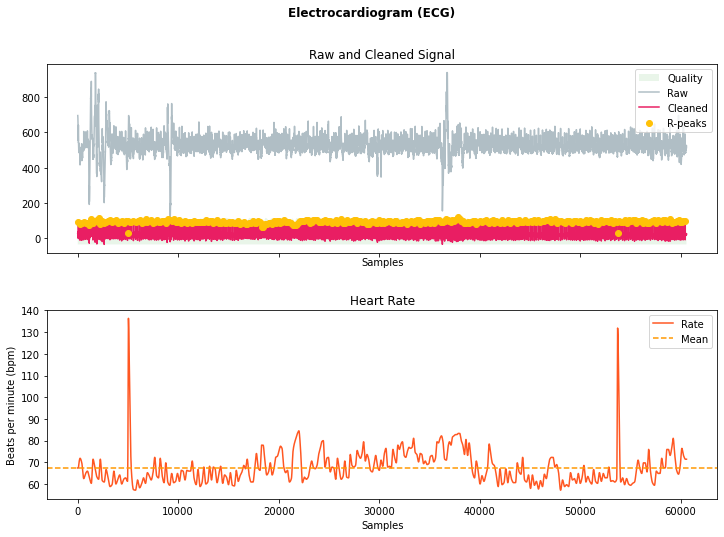

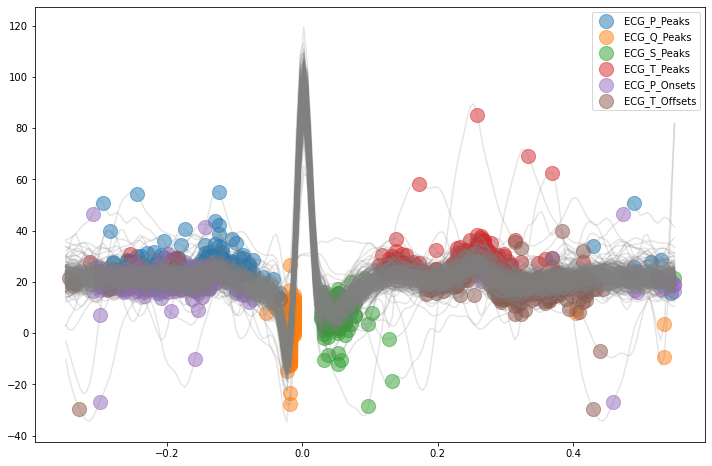

In [22]:
!pip install neurokit2 
#installing neurokit2 library 

import pandas as pd #importing pandas
import numpy as np  #importing numpy
import matplotlib.pyplot as plt #importing matplotlib for plotting
import neurokit2 as nk #importing neurokit2
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]  #setting graph size
plt.close()

#Importing the Signal Code
#pandas dataframe reads the signal, beware the input file can contain bad values.
FILENAME = "ECG Data/223DF2" #Filname. Change this when importing new file.

def load_and_plot_signal(Filename): #Takes filename and loads the signal and plots it
    print("Loading "+Filename+'.txt')
    df=pd.read_table(Filename+".txt",header=None) 

    #converting the pandas dataframe to numpy array for further processing
    ecg_sig=df[0]
    plt.figure()
    plt.plot(ecg_sig)
    plt.xlabel("samples",fontsize=16)
    plt.ylabel("amplitude",fontsize=16)
    plt.title("Complete Signal")
    plt.show()

    return ecg_sig

 
def preprocessing(ecg,fs): #preprocesses the signal by cleaning it using filters, finds Rpeaks, Heart Rate and Quality of signal
    # Do processing
    ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=fs,method="biosppy") #Filters and Clean the Signal
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)#Find R-Peaks from the Signals
    rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=len(ecg_cleaned))#Find Heart Rate from each QRS complex
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=fs)#Checks the quality of the signal.
    
    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality
                            })
    signals = pd.concat([signals, instant_peaks], axis=1)
    info = rpeaks
    
   
    return signals, info


def extract_features_and_save(ecg_sig,fs,RR_peaks,filename): #Extract Features like P,Q,S,T peaks and P and T offsets 
    
    features=nk.ecg_delineate(ecg_sig, rpeaks=RR_peaks, sampling_rate=fs, method='peaks', show=True, show_type='all', check=False)
    f=pd.DataFrame(features[0])
    f.to_csv(filename+"_features.csv")
    HRV=nk.hrv_time(RR_peaks, sampling_rate=fs, show=False)
    print(HRV)
    hrv=pd.DataFrame(HRV)
    hrv.to_csv(filename+"_HRV_features.csv",index=False)
    return hrv,f

def arythmia_detection(ecg_signal_rate,filename): #Take mean heart rate and detects arythmias
    #According to literature if Heart Rate < 60/min that means Bradycardia
    #If Heart > 100/min that means Tracycardia otherwise signal is normal. 
    isNormal=0
    isTracycardia=0
    isBradycardia=0
    print(ecg_signal_rate)
    data=[{'isNormal':0,
          'isTracycardia':0,
          'isBradycardia':0}]
    
    arythmia= pd.DataFrame(data)
    
    if (ecg_signal_rate<60):
        #isBradycardia=1
        arythmia['isBradycardia']=1
    elif (ecg_signal_rate>100):
        arythmia['isTracycardia']=1
    else:
        #isNormal=1
        arythmia["isNormal"]=1
    print(arythmia)
    arythmia.to_csv(filename+"_arythmias_detection.csv",index=False)
    
#Calling Functions
ecg_sig=load_and_plot_signal(FILENAME) #Loading ECG_Signal

N= len(ecg_sig) #Length of a signal
fs=200 #Sampling frequency of the signal
T=1/fs #Time period of the Signal
seconds=np.linspace(0,(N*T),N) #Converting samples to time(seconds)

#Processing the signals
processed_signal,RR_peaks = preprocessing(ecg_sig,200)
#Saving Clean signal in file

processed_signal["ECG_Clean"].to_csv(FILENAME+'_clean.csv')


#Plotting processed signal
plot=nk.ecg_plot(processed_signal)

#Extracting the features
hrv,features=extract_features_and_save(processed_signal["ECG_Clean"],fs,RR_peaks,FILENAME)

#Arythmia Detections
arythmia_detection(np.mean(processed_signal["ECG_Rate"]),FILENAME)



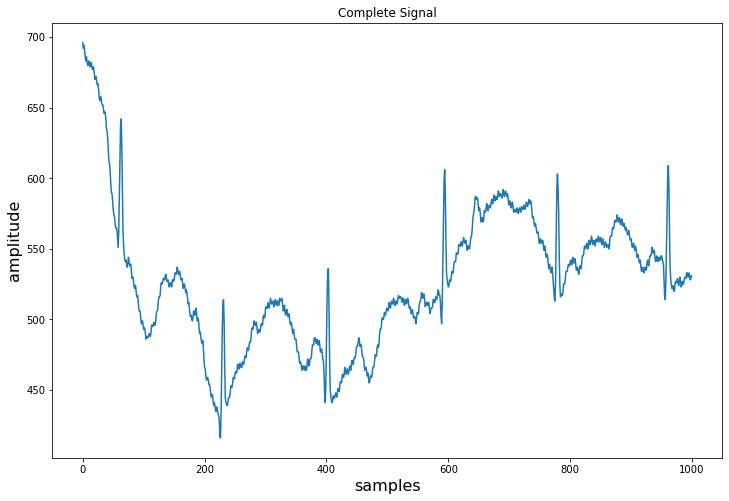

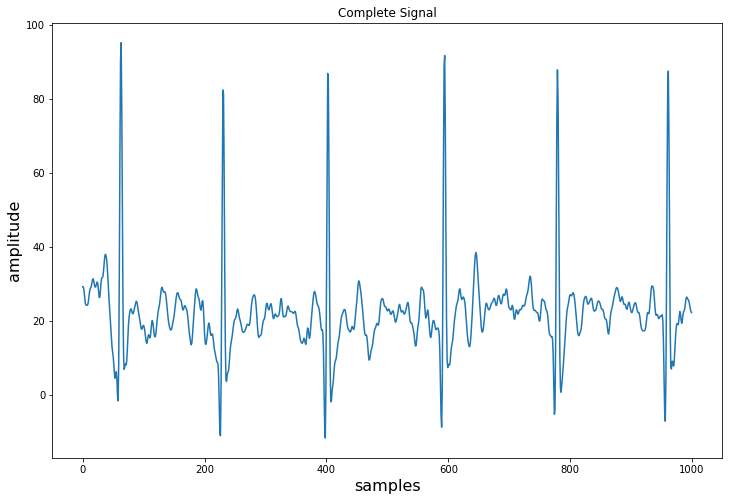

In [47]:
plt.figure()
plt.plot(ecg_sig[:1000])
plt.xlabel("samples",fontsize=16)
plt.ylabel("amplitude",fontsize=16)
plt.title("Complete Signal")
plt.show()


plt.figure()
plt.plot(processed_signal["ECG_Clean"][:1000])
plt.xlabel("samples",fontsize=16)
plt.ylabel("amplitude",fontsize=16)
plt.title("Complete Signal")
plt.show()